In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat#读取矩阵文件
from scipy.optimize import minimize#非线性规划优化

### 加载数据集

In [32]:
def load_data(path):
    data = loadmat(path)
    X = data['X']
    y = data['y']
    return X,y

X, y = load_data('./ex3data1.mat')
print(np.unique(y))  # 看下有几类标签
# [ 1  2  3  4  5  6  7  8  9 10]
X.shape, y.shape
# ((5000, 400), (5000, 1))
#print(X)
#print(y)

[ 1  2  3  4  5  6  7  8  9 10]


((5000, 400), (5000, 1))

### 可视化

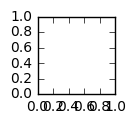

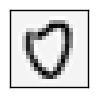

this should be [10]
[3352 1222 1455 2794 4526 1016  721 4023 4959  351 4342 2044 2657 4538 3176
 3003 2799 2666 4976 1384 2620 3302 1017 3428 1031 4837  348 1478 2495 4990
 4838 3229 3590 3204  557 4384 3832 2370 1375  365 2277 2372 4110 4523 3963
  477 2982 3382 1499 3387 2462 4270 3630  704 3411 2424 3874 1323 1891 4229
 1809 1820 4965 1535 3231 1788 4827 4391  167 2213 2161 1550 2355 4595 1081
 3262  643 2743  188 2291 4218 4044 1026 4974  801 3060  850 4963 2109 4996
 2597 4951 2495 2358 4124 4261 2688 3891 3775 3100]
(100, 400)


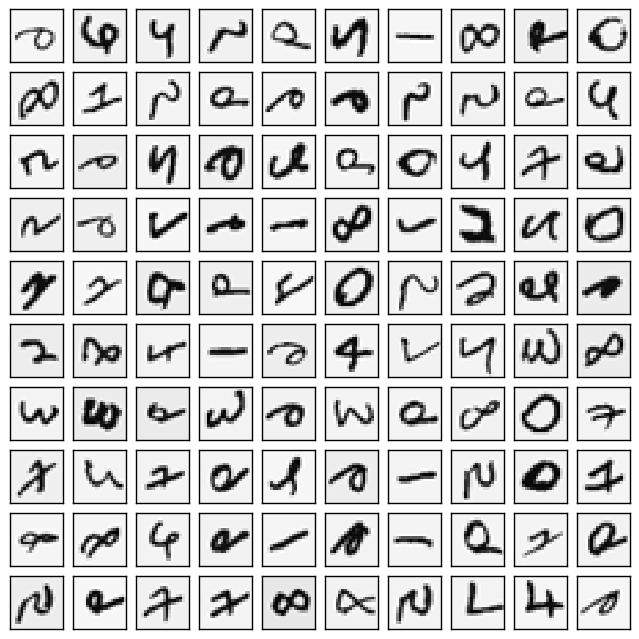

In [33]:
def plot_an_image(X):
    """
    随机打印一个数字
    """
    pick_one = np.random.randint(0, 5000)
    image = X[pick_one, :]
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20, 20)), cmap='gray_r')
    plt.xticks([])  # 去除刻度，美观
    plt.yticks([])
    plt.show()
    print('this should be {}'.format(y[pick_one]))

plot_an_image(X)

def plot_100_image(X):
    """ 
    随机画100个数字
    """
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 随机选100个样本
    print(sample_idx)
    sample_images = X[sample_idx, :]  # (100,400)
    print(sample_images.shape)
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for row in range(10):
        for column in range(10):
            ax_array[row, column].matshow(sample_images[10 * row + column].reshape((20, 20)),
                                   cmap='gray_r')
    plt.xticks([])
    plt.yticks([])        
    plt.show()
    
plot_100_image(X)

### 向量化逻辑回归

In [27]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#正则化的代价函数
def regularized_cost(theta, X, y, l):
    """
    don't penalize theta_0
    args:
        X: feature matrix, (m, n+1) # 插入了x0=1
        y: target vector, (m, )
        l: lambda constant for regularization
    """
    thetaReg = theta[1:]
    first = (-y*np.log(sigmoid(X@theta))) + (y-1)*np.log(1-sigmoid(X@theta))
    reg = (thetaReg@thetaReg)*l / (2*len(X))#正则项
    return np.mean(first) + reg

#正则化梯度
def regularized_gradient(theta, X, y, l):
    """
    don't penalize theta_0
    args:
        l: lambda constant
    return:
        a vector of gradient
    """
    thetaReg = theta[1:]
    first = (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)
    # 这里人为插入一维0，使得对theta_0不惩罚，方便计算
    reg = np.concatenate([np.array([0]), (l / len(X)) * thetaReg])#正则项
    return first + reg

In [28]:
#一对多分类
def one_vs_all(X, y, l, K):
    """generalized logistic regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization
        K: numbel of labels
    return: trained parameters
    """
    all_theta = np.zeros((K, X.shape[1]))  # (10, 401)
    
    for i in range(1, K+1):
        theta = np.zeros(X.shape[1])
        y_i = np.array([1 if label == i else 0 for label in y])
    
        ret = minimize(fun=regularized_cost, x0=theta, args=(X, y_i, l), method='TNC',
                        jac=regularized_gradient, options={'disp': True})
        all_theta[i-1,:] = ret.x
                         
    return all_theta

In [29]:
# 模型预测准确率
def predict_all(X, all_theta):
    # compute the class probability for each class on each training instance   
    h = sigmoid(X @ all_theta.T)  # 注意的这里的all_theta需要转置
    # create array of the index with the maximum probability
    # Returns the indices of the maximum values along an axis.
    h_argmax = np.argmax(h, axis=1)
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
raw_X, raw_y = load_data('ex3data1.mat')
X = np.insert(raw_X, 0, 1, axis=1) # (5000, 401)
y = raw_y.flatten()  # 这里消除了一个维度，方便后面的计算 or .reshape(-1) （5000，）

all_theta = one_vs_all(X, y, 1, 10)
print(all_theta)  # 每一行是一个分类器的一组参数

y_pred = predict_all(X, all_theta)
accuracy = np.mean(y_pred == y)
print ('accuracy = {0}%'.format(accuracy * 100))

[[ -2.38120632e+00   0.00000000e+00   0.00000000e+00 ...,   1.30520871e-03
   -9.34051816e-10   0.00000000e+00]
 [ -3.18336957e+00   0.00000000e+00   0.00000000e+00 ...,   4.46340223e-03
   -5.08880580e-04   0.00000000e+00]
 [ -4.79894740e+00   0.00000000e+00   0.00000000e+00 ...,  -2.86619702e-05
   -2.47209891e-07   0.00000000e+00]
 ..., 
 [ -7.98738710e+00   0.00000000e+00   0.00000000e+00 ...,  -8.94653400e-05
    7.21239651e-06   0.00000000e+00]
 [ -4.57199032e+00   0.00000000e+00   0.00000000e+00 ...,  -1.33791002e-03
    9.99342936e-05   0.00000000e+00]
 [ -5.40412466e+00   0.00000000e+00   0.00000000e+00 ...,  -1.16606730e-04
    7.87540219e-06   0.00000000e+00]]
accuracy = 0.0%


C:\Users\13126\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
